# This LSTM model will use Semaine+RECOLA as input and use JLCorpus as the validation set to predict Arousal from 7 features


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
tf.test.gpu_device_name()
!/opt/bin/nvidia-smi

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.chdir('/content/drive/Shareddrives/Part IV 700 - Siwei Yang and Sky Nguyen/Colab')
print('Current Working Directory ' , os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fri Oct  1 14:59:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |    541MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import r2_score
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [ ]:
def timeTag():
    # YYmmddHHMM
    return datetime.now().strftime('[%Y%m%d%H%M]')

tTag = timeTag()

In [ ]:
def ccc(x,y):
    '''Concordance Correlation Coefficient'''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    return rhoc

In [ ]:
def dispCCC(df):
    # Get CCC
    cccVal = ccc(df.loc[:,df.columns[0]], df.loc[:,df.columns[1]])
    cccVal = np.array2string(cccVal, precision=4)
    print('\t\t'+df.columns[0]+'\t\t'+df.columns[1])
    print(df.columns[0]+'\t\t'+'1.0000'+'\t\t'+cccVal)
    print(df.columns[1]+'\t'+cccVal+'\t\t'+'1.0000')

In [ ]:
# prepare data for lstms
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Define scaler, feature number and number of step looking back
scale_range = (0, 1)
scaler = MinMaxScaler(feature_range=scale_range)
n_steps = 24  # exclude the current step
n_features = 7

usingJL = False
transformTarget = True

if usingJL:
    jlTag = 'aRs2j'
else:
    jlTag = 'aRs'

In [ ]:
# read datasets, first n_steps data will be skipped
# Possible columns: Time,Valence,Arousal,RMS,F0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,FileName,voiceTag
if usingJL:
    trainingDataset = pd.read_csv('inputFile/modelInput/allFileCombineP.csv')
    targetOfTrainingDataset = trainingDataset['Arousal'][n_steps:]
    trainingDataset = trainingDataset[['RMS', 'F0', 'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5']]
    print(trainingDataset.head(5))

    testingDataset = pd.read_csv('inputFile/modelInput/jlco0000st.csv')
    targetOfTestingDataset = testingDataset['Arousal'][n_steps:]
    testingDataset = testingDataset[['RMS', 'F0', 'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5']]
    print(trainingDataset.head(5))
else:
    trainingDataset = pd.read_csv('inputFile/modelInput/allFileCombineP.csv')
    targetOfTrainingDataset = trainingDataset['Arousal'][n_steps:]
    trainingDataset = trainingDataset[['RMS', 'F0', 'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5']]
    print(trainingDataset.head(5))

         RMS         F0     MFCC1      MFCC2     MFCC3      MFCC4      MFCC5
0   0.000000   0.000000    0.0000   0.000000   0.00000   0.000000   0.000000
1   0.000000   0.000000    0.0000   0.000000   0.00000   0.000000   0.000000
2   0.000000   0.000000    0.0000   0.000000   0.00000   0.000000   0.000000
3   0.000000   0.000000    0.0000   0.000000   0.00000   0.000000   0.000000
4 -60.325294  55.160935 -533.2911  48.249077  14.81778  20.503918  17.566671


In [ ]:
if usingJL:
    # load and build training dataset
    values = trainingDataset.values
    # normalize features
    trainingScaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(trainingScaled, n_steps, 1)
    print(reframed.shape)
    values = reframed.values
    train = values

    # load and build testing dataset
    values = testingDataset.values
    # normalize features
    testingScaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(testingScaled, n_steps, 1)
    print(reframed.shape)
    values = reframed.values
    test = values
else:
    values = trainingDataset.values
    # normalize features
    trainingScaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(trainingScaled, n_steps, 1)
    print(reframed.shape)
    # split into train and test sets
    values = reframed.values
    n_train_steps =  1650780 # 97% of dataset, total length: 1834200 (10.19 hours)
    train = values[:n_train_steps, :]
    test = values[n_train_steps:, :]

(36892, 28)


In [ ]:
# transforming targets
if transformTarget:
    trainingyScaled = scaler.fit_transform(np.array(targetOfTrainingDataset).reshape(-1, 1))

    # seems no need to scale the test y, as it is only used for comparison
    # testingyScaled = scaler.fit_transform(np.array(targetOfTestingDataset).reshape(-1, 1))

In [ ]:
# split into input and outputs
if usingJL:
    if transformTarget:
        train_X, train_y = train, trainingyScaled[:, 0]
    else:
        train_X, train_y = train, targetOfTrainingDataset

    test_X = test
    test_y = targetOfTestingDataset
else:
    if transformTarget:
        train_X, train_y = train, trainingyScaled[:n_train_steps, 0]
    else:
        train_X, train_y = train, targetOfTrainingDataset[:n_train_steps]
    test_X, test_y = test, targetOfTrainingDataset[n_train_steps:]
    print(train_X.shape, train_y.shape)

(36892, 28) (36892,)


In [ ]:
# reshape input to be 3D [samples, timesteps (n_steps before + 1 current step), features]
train_X = train_X.reshape((train_X.shape[0], n_steps + 1, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps + 1, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(36892, 4, 7) (36892,) (0, 4, 7) (0,)


In [ ]:
# Parameters
batch_size = 75
epochs = 70
validation_split = 0.3
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/
usingCheckPoint = False
continueTraining = False

customAdam = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-06,
    amsgrad=False,
    name='Adam',
)

def create_model():
    model = keras.Sequential([
        # no dropout and activation in LSTM if using cuDNN kernel
        layers.LSTM(56, input_shape=(train_X.shape[1], train_X.shape[2])),
        layers.Dense(1),
    ])
    model.compile(optimizer=customAdam, loss='mse')
    return model

In [ ]:
if not usingCheckPoint:
    # Create a KerasClassifier with best parameters
    model = KerasRegressor(build_fn=create_model, batch_size=batch_size, epochs=epochs, shuffle=False)

    # Calculate the accuracy score for each fold
    kfolds = cross_val_score(model, train_X, train_y, cv=5, scoring='r2')

    # Get the accuracy
    print('The mean accuracy:', kfolds.mean())

Epoch 1/150
5903/5903 [==============================] - 16s 3ms/step - loss: 0.0125
Epoch 2/150
5903/5903 [==============================] - 15s 3ms/step - loss: 0.0140
Epoch 3/150
5903/5903 [==============================] - 15s 3ms/step - loss: 0.0146
Epoch 4/150
5903/5903 [==============================] - 15s 3ms/step - loss: 0.0144
Epoch 5/150
5903/5903 [==============================] - 15s 3ms/step - loss: 0.0143
Epoch 6/150
5903/5903 [==============================] - 15s 3ms/step - loss: 0.0143
Epoch 7/150
5903/5903 [==============================] - 15s 3ms/step - loss: 0.0143
Epoch 8/150
5903/5903 [==============================] - 15s 3ms/step - loss: 0.0143
Epoch 9/150
5903/5903 [==============================] - 15s 2ms/step - loss: 0.0143
Epoch 10/150
5903/5903 [==============================] - 15s 3ms/step - loss: 0.0143
Epoch 11/150
5903/5903 [==============================] - 15s 3ms/step - loss: 0.0142
Epoch 12/150
5903/5903 [==============================] - 15s 3

In [ ]:
# use callbacks
checkpoint = ModelCheckpoint(filepath='outputFile/models/bestWeight.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=14, mode='auto', restore_best_weights=True)

In [ ]:
if usingCheckPoint:
    # Create model
    model = create_model()
    # Load weights
    model.load_weights('outputFile/models/bestWeight.hdf5')
    # Compile model (required to make predictions)
    model.compile(optimizer=customAdam, loss='mse')
    print('Created model and loaded weights from file')
    if continueTraining:
        newEpochs = 10
        history = model.fit(train_X, train_y, epochs=newEpochs, batch_size=batch_size, validation_split=validation_split, verbose=2, shuffle=False, callbacks=[early_stop, checkpoint, reduce_lr])
else:
    # Fit network [3, 3, 5, 5, 3433]
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=2, shuffle=False, callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/150
5165/5165 - 15s - loss: 0.0142 - val_loss: 0.1419

Epoch 00001: val_loss improved from -inf to 0.14187, saving model to outputFile/models/bestWeight.hdf5
Epoch 2/150
5165/5165 - 14s - loss: 0.0136 - val_loss: 0.1089

Epoch 00002: val_loss did not improve from 0.14187
Epoch 3/150
5165/5165 - 14s - loss: 0.0138 - val_loss: 0.0924

Epoch 00003: val_loss did not improve from 0.14187
Epoch 4/150
5165/5165 - 14s - loss: 0.0138 - val_loss: 0.0754

Epoch 00004: val_loss did not improve from 0.14187
Epoch 5/150
5165/5165 - 14s - loss: 0.0138 - val_loss: 0.0667

Epoch 00005: val_loss did not improve from 0.14187
Epoch 6/150
5165/5165 - 14s - loss: 0.0138 - val_loss: 0.0625

Epoch 00006: val_loss did not improve from 0.14187
Epoch 7/150
5165/5165 - 14s - loss: 0.0138 - val_loss: 0.0601

Epoch 00007: val_loss did not improve from 0.14187
Epoch 8/150
5165/5165 - 14s - loss: 0.0137 - val_loss: 0.0581

Epoch 00008: val_loss did not improve from 0.14187
Epoch 9/150
5165/5165 - 14s - loss: 

In [ ]:
# save the model
model.model.save('outputFile/models/'+tTag+jlTag+'Model')
# https://stackoverflow.com/questions/42666046/loading-a-trained-keras-model-and-continue-training

INFO:tensorflow:Assets written to: outputFile/models/[202110011459]aRsModel/assets


INFO:tensorflow:Assets written to: outputFile/models/[202110011459]aRsModel/assets


dict_keys(['loss', 'val_loss', 'lr'])


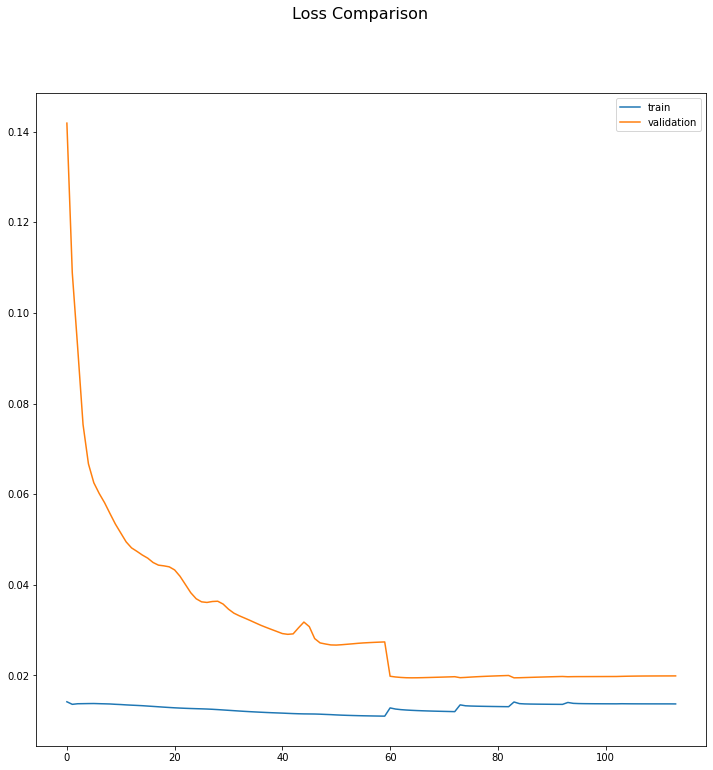

In [ ]:
# plot loss history
print(history.history.keys())
plt.ioff()
fig = plt.figure(figsize=[12, 12])
fig.suptitle('Loss Comparison', fontsize=16)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.savefig('outputFile/models/'+tTag+jlTag+'Model/'+'trainLossVsValLoss.png', format='png')
plt.show()
# plt.close(fig)

In [ ]:
# make a prediction
if transformTarget:
    inv_yPredict = model.predict(test_X)
    # inv transform the predicted value
    yPredict = scaler.inverse_transform(inv_yPredict.reshape(-1, 1))
    yPredict = yPredict[:, 0]
else:
    yPredict = model.predict(test_X)

# actual value
yActual = test_y
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yActual, yPredict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.245


In [ ]:
r2_score(yActual, yPredict)

-0.26491829035516545

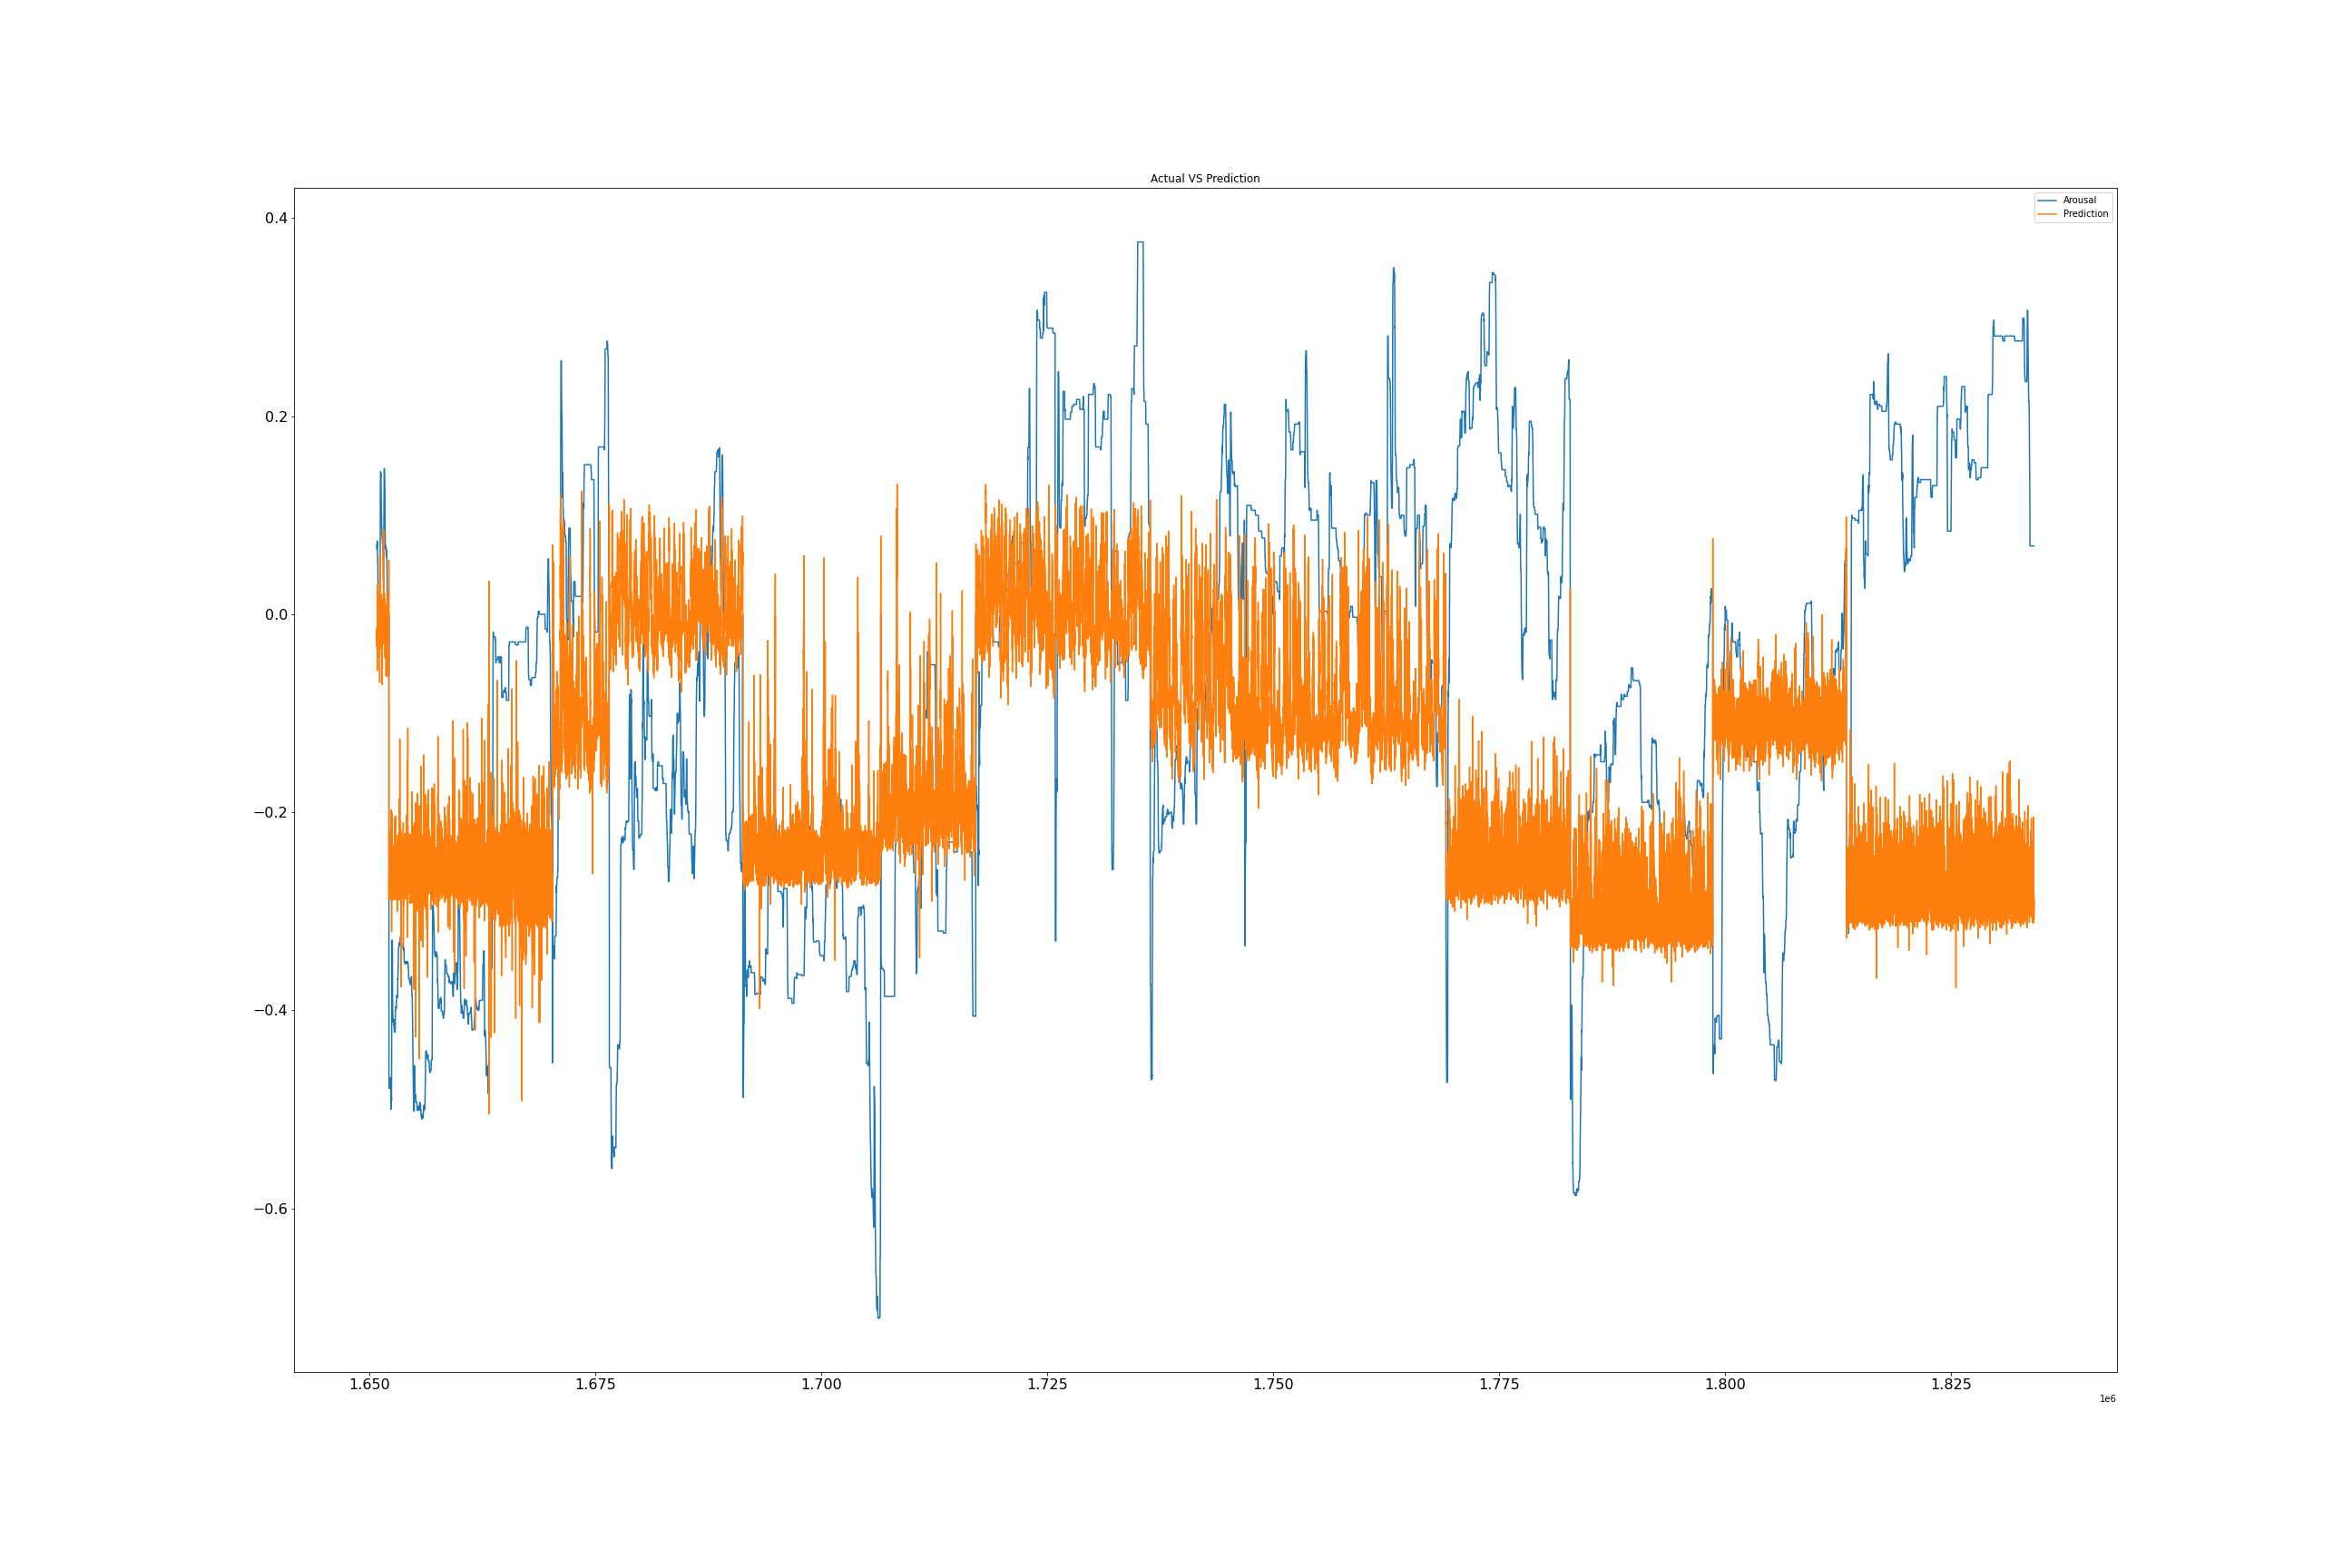

In [ ]:
plt.ioff()
pred_test_list = [i for i in yPredict]
submission = pd.DataFrame({'Arousal': yActual, 'Prediction': pred_test_list})
submission.loc[1:, ['Arousal', 'Prediction']].plot(figsize=(36, 24), title='Actual VS Prediction', fontsize=16)
plt.savefig('outputFile/models/'+tTag+jlTag+'Model/'+'actualVsPrediction.png', format='png')
plt.savefig('outputFile/models/'+tTag+jlTag+'Model/'+'actualVsPrediction.svg', format='svg')
plt.show()
# plt.close(fig)
submission.to_csv('outputFile/models/'+tTag+jlTag+'Model/'+'submission.csv', index=False)

# print(pred_test_list[1000:1150])

In [ ]:
correlation = submission.corr(method='pearson')
print('Pearson Correlation')
print(correlation)
print()
print('Concordance Correlation Coefficient')
dispCCC(submission)

Pearson Correlation
             Arousal  Prediction
Arousal     1.000000    0.16453
Prediction  0.16453    1.000000

Concordance Correlation Coefficient
		Arousal		Prediction
Arousal		1.0000		0.1198
Prediction	0.1198		1.0000


<Figure size 1728x1728 with 0 Axes>

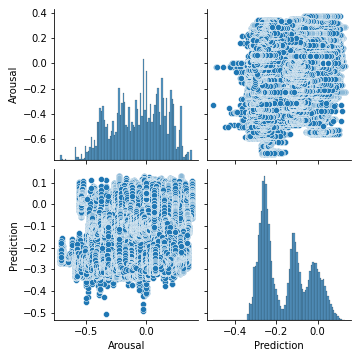

In [ ]:
d0 = submission[['Arousal', 'Prediction']]
plt.ioff()
fig = plt.figure(figsize=[24, 24])
fig.suptitle('Actual Prediction Correlation', fontsize=16)
sns.pairplot(d0, kind='scatter')
plt.savefig('outputFile/models/'+tTag+jlTag+'Model/'+'actualPredictionCorrelation.png', format='png')
plt.savefig('outputFile/models/'+tTag+jlTag+'Model/'+'actualPredictionCorrelation.svg', format='svg')
plt.show()
# plt.close(fig)